# Supervised Learning Model

Now I am going to train a **Supervised ML model that uses demographics information from each individual** and decides whether or not it will be worth it to include a person in the marketing campaign.

Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43000 data rows.

`Udacity_MAILOUT_052018_TRAIN.csv` will be splitted into train and verification sets. The instances in this datasets are labelled indicating in a person became a customer of the company following the marketing campaign.

Then, I will use the model to make predictions on test data `Udacity_MAILOUT_052018_TEST.csv`.

In [123]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle5 as pickle

from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

# magic word for producing visualizations in notebook
%matplotlib inline

# 1.EDA 

In [33]:
def load_data(path_file, dtype, sep):
    """It loads in a .csv file and turn it into a pandas df.
    Parameters
    __________
    :param path_file: string. Path file
    :param dtype: dict. dtype for pd.read_csv pandas method
    :param sep: string. separator for pd.read_csv pandas method
    __________
    :return: .csv file converted into a Pandas DataFrame
    """
    return pd.read_csv(path_file, dtype=dtype, sep=sep)

In [49]:
mailout_train = load_data('../data/Udacity_MAILOUT_052018_TRAIN.csv',
                          dtype={'CAMEO_DEUG_2015': 'str', 'CAMEO_INTL_2015': 'str'},
                          sep=','
                         )
mailout_train.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [185]:
mailout_train.shape

(42962, 368)

In [222]:
mailout_test = load_data('../data/Udacity_MAILOUT_052018_TEST.csv',
                               dtype={'CAMEO_DEUG_2015': 'str', 'CAMEO_INTL_2015': 'str'},
                               sep=','
                               )

In [223]:
mailout_test.shape

(42833, 367)

The dataset contains 368 features. This is the 367 features in AZDIAS dataframe used for the Customer Segmentation Report plus the `RESPONSE` feature.

In [15]:
# check features are the same as in AZDIAS
azdias_df = load_data('../data/Udacity_AZDIAS_052018.csv',
                          dtype={'CAMEO_DEUG_2015': 'str', 'CAMEO_INTL_2015': 'str'}, sep=','
                          )
azdias_df.head()

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [27]:
assert np.setdiff1d(np.array(mailout_train.columns), np.array(azdias_df.columns)) == np.array(['RESPONSE']), "Difference in columns"

Note though that columns might be in a different order.

In [28]:
# check variables with categorical data
mailout_train.describe(exclude=np.number)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
count,35074,35074,35074,35378,35185,35185
unique,45,19,43,35,1599,2
top,6B,6.0,24.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
freq,2452,3884,3024,10276,18156,26752


Same as in azdias df.

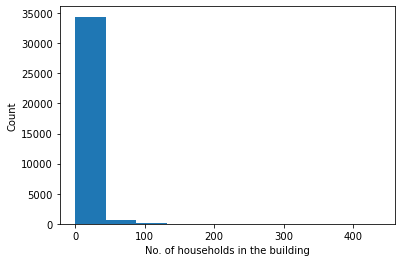

In [29]:
# Outliers - plot variable distribution
plt.hist(mailout_train['ANZ_HAUSHALTE_AKTIV'].dropna().values)
plt.xlabel("No. of households in the building")
plt.ylabel("Count")
plt.show()

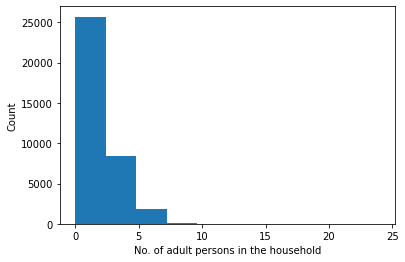

In [30]:
# Outliers - plot variable distribution
plt.hist(mailout_train['ANZ_PERSONEN'].dropna().values)
plt.xlabel("No. of adult persons in the household")
plt.ylabel("Count")
plt.show()

Same as in azdias df.

The features distributions and their values are very similar so I can adapt the functions in `data_preprocessing.py` script to perform data preprocessing on mailout data.

# 2. Data Preprocessing

I am gonna clean and preprocessed `Udacity_MAILOUT_052018_TRAIN.csv` using a python script called `supervised_model_data_preprocessing.py` that contains very similar functions to the ones in `data_preprocessing.py`.

To run the python script in a mac terminal: *python supervised_model_data_preprocessing.py '../data/Udacity_MAILOUT_052018_TRAIN.csv' 'train'*.

In [32]:
def load_pickle(file_path):
    """It loads a pickle file."""
    file = open(file_path,'rb')
    object_file = pickle.load(file)
    file.close()
    return object_file

In [186]:
# load in preprocessed training data
preprocessed_mailout_train = load_pickle("../data/MAILOUT_TRAIN_DF.pkl")
preprocessed_mailout_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1,4,13,13,1,0,0,2,1,0,...,1,2,1,4,9,7,1,0,2,3
1,2,1,6,6,4,0,0,2,4,0,...,8,11,11,6,9,1,3,0,2,4
2,1,1,8,8,2,0,0,1,1,0,...,6,6,3,6,9,2,3,0,2,4
3,2,1,13,13,1,0,0,2,1,0,...,1,1,1,6,9,7,3,0,2,4
4,2,1,8,8,2,0,0,2,2,0,...,7,8,5,6,9,7,3,0,1,4


In [224]:
# load in preprocessed test data
preprocessed_mailout_test = load_pickle("../data/MAILOUT_TEST_DF.pkl")
preprocessed_mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1,7,6,2,0,0,2,2,...,4,5,6,3,6,9,3,3,1,4
1,1770,2,1,9,9,20,0,0,1,21,...,1,5,2,1,6,9,5,3,1,4
2,1465,2,9,16,11,2,0,0,4,2,...,3,9,6,3,2,9,4,3,2,4
3,1470,2,7,9,9,1,0,0,1,1,...,2,6,6,3,6,9,2,3,2,4
4,1478,1,1,21,13,1,0,0,4,1,...,1,2,4,3,3,9,7,4,2,4


In [225]:
# convert dataframes to floats
preprocessed_mailout_train = preprocessed_mailout_train.astype('float64').copy()
preprocessed_mailout_test = preprocessed_mailout_test.astype('float64').copy()

In [226]:
# convert RESPONSE to integer
preprocessed_mailout_train['RESPONSE'] = preprocessed_mailout_train['RESPONSE'].astype('int')

# 3. Train / validation split

In [192]:
# separate response from predictors
X = preprocessed_mailout_train.drop('RESPONSE', axis=1).copy()
y = preprocessed_mailout_train['RESPONSE'].copy()

# split training dataset into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# 4. ML Pipeline

## 4.1. Class Imbalance

I know that this is an **imbalance dataset**. I will use SMOTE combined with undersampling of the majority class.

I will also use a balanced model such as BalancedRandomForestClassifier or similar.


In [193]:
# summarise class distribution
counter = Counter(y)
print(counter)
"1:{} ratio".format(int(round((counter[0] / counter[1]),0)))

Counter({0: 17324, 1: 255})


'1:68 ratio'

## 4.2. Pipeline and spot-checks

### 4.2.1. Spot-check RandomForestClassifier

In [194]:
# define pipeline steps
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1) # oversampling minority class by 10%
under = RandomUnderSampler(sampling_strategy=0.5) # undersample majority class by 50%
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

steps = [
    ('scaler', scaler),
    ('over', over),
    ('under', under),
    ('clf', clf)
]

pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean roc auc:', scores.mean())

Mean roc auc: 0.6682893193807069


### 4.2.2. Spot-check BalancedRandomForestClassifier

In [195]:
# define pipeline steps
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1) # oversampling minority class by 10%
under = RandomUnderSampler(sampling_strategy=0.5) # undersample majority class by 50%
clf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

steps = [
    ('scaler', scaler),
    ('over', over),
    ('under', under),
    ('clf', clf)
]

pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean roc auc:', scores.mean())

Mean roc auc: 0.6901651015416926


### 4.2.3. Spot-check XGBClassifier

In [196]:
# define pipeline steps
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1) # oversampling minority class by 10%
under = RandomUnderSampler(sampling_strategy=0.5) # undersample majority class by 50%
clf = XGBClassifier(random_state=42)

steps = [
    ('scaler', scaler),
    ('over', over),
    ('under', under),
    ('clf', clf)
]

pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean roc auc:', scores.mean())

Mean roc auc: 0.7190005023445788


### 4.2.4. Spot-check ADABoostClassifier with BalancedRandomForestClassifier

In [197]:
# define pipeline steps
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1) # oversampling minority class by 10%
under = RandomUnderSampler(sampling_strategy=0.5) # undersample majority class by 50%
clf = AdaBoostClassifier(base_estimator=BalancedRandomForestClassifier(), n_estimators=100, random_state=42)

steps = [
    ('scaler', scaler),
    ('over', over),
    ('under', under),
    ('clf', clf)
]

pipeline = Pipeline(steps=steps)

# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean roc auc:', scores.mean())

Mean roc auc: 0.6967862365847785


### 4.2.5. Conclusion

The most promising model seems to tbe **XGBClassifier**. I am going to fine-tune the hyperparameters using GridSearchCV.

## 4.3. Fine-tune tranformers parameters and hyper-parameters

In [117]:
# define XGBClassifier pipeline
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.1) # oversampling minority class by 10%
under = RandomUnderSampler(sampling_strategy=0.5) # undersample majority class by 50%
clf = XGBClassifier(random_state=42)

steps = [
    ('scaler', scaler),
    ('over', over),
    ('under', under),
    ('clf', clf)
]

pipeline = Pipeline(steps=steps)

# get pipeline parameters
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('over', SMOTE(sampling_strategy=0.1)),
  ('under', RandomUnderSampler(sampling_strategy=0.5)),
  ('clf',
   XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                 colsample_bynode=None, colsample_bytree=None, gamma=None,
                 gpu_id=None, importance_type='gain', interaction_constraints=None,
                 learning_rate=None, max_delta_step=None, max_depth=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=None, num_parallel_tree=None,
                 random_state=42, reg_alpha=None, reg_lambda=None,
                 scale_pos_weight=None, subsample=None, tree_method=None,
                 validate_parameters=None, verbosity=None))],
 'verbose': False,
 'scaler': StandardScaler(),
 'over': SMOTE(sampling_strategy=0.1),
 'under': RandomUnderSampler(sampling_strategy=0.5),
 'clf': XGBClassifier(base_score=N

In [118]:
# define parameters for GridSearchCV
parameters = {
    'over__sampling_strategy': [0.2, 0.4, 0.7],
    'under__sampling_strategy': [0.4, 0.6, 0.8],
    'clf__n_estimators': [50, 100, 150, 300],
    'clf__max_depth': [50, 150, 300],
    'clf__learning_rate': [0.001, 0.01, 0.1],
    'clf__booster': ('gbtree', 'gblinear', 'dart'),  
}

In [119]:
# run GridSearchCV
cv = GridSearchCV(pipeline, param_grid=parameters, scoring='roc_auc', n_jobs=-1)
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('over', SMOTE(sampling_strategy=0.1)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      l...
 

In [121]:
# get best_params
cv.best_params_

{'clf__booster': 'gbtree',
 'clf__learning_rate': 0.1,
 'clf__max_depth': 150,
 'clf__n_estimators': 100,
 'over__sampling_strategy': 0.4,
 'under__sampling_strategy': 0.4}

I am going to use this parameters. I could have spent more time on fine-tuning the hyperparameters but it took +4h to run GridSearchCV on my laptop so I will stick to these ones.

# 5. Model Validation

I need to validate the model with the validation set that I put apart in the beginning befor making predictions on the test set.

I am gonna tweak manually the parameters over__sampling_strategy and under__sampling_strategy to try to make the model pay more attention to the minority class.

In [205]:
# define XGBClassifier pipeline and tweak sampling parameters manually
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.4) # oversampling minority class by 40%
under = RandomUnderSampler(sampling_strategy=0.6) # undersample majority class by 60%
clf = XGBClassifier(booster='gbtree', learning_rate=0.1, n_estimators=100, random_state=42)

steps = [
    ('scaler', scaler),
    ('over', over),
    ('under', under),
    ('clf', clf)
]

pipeline = Pipeline(steps=steps)

# fit pipeline on train set
pipeline.fit(X_train, y_train)

# make predictions
y_preds = pipeline.predict_proba(X_val)

# score
score = roc_auc_score(y_val, y_preds[:, 1])
print("Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction score is {}".format(score))

Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction score is 0.7246471020853598


In [206]:
# summarise class distribution
counter = Counter(y_train)
print(counter)
"1:{} ratio".format(int(round((counter[0] / counter[1]),0)))

Counter({0: 13869, 1: 194})


'1:71 ratio'

In [207]:
counter = Counter(y_val)
print(counter)
"1:{} ratio".format(int(round((counter[0] / counter[1]),0)))

Counter({0: 3455, 1: 61})


'1:57 ratio'

Both train and validation sets are highly skewed towards the majority class. I have tried to handle this imbalance dataset by applying oversampling and undersampling techniques but with limited success. I could further fine-tune the hyperparameters but it is computationally expensive for my personal laptop. I will test this model on the test set as is.

# 6. Kaggle Competition - Performance on test set

Entry to the competition with a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [227]:
preprocessed_mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754.0,2.0,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3.0,1.0,4.0
1,1770.0,2.0,1.0,9.0,9.0,20.0,0.0,0.0,1.0,21.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3.0,1.0,4.0
2,1465.0,2.0,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3.0,2.0,4.0
3,1470.0,2.0,7.0,9.0,9.0,1.0,0.0,0.0,1.0,1.0,...,2.0,6.0,6.0,3.0,6.0,9.0,2.0,3.0,2.0,4.0
4,1478.0,1.0,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4.0,2.0,4.0


In [228]:
# save LNR column
LNR_col = preprocessed_mailout_test['LNR'].astype('int32')

In [229]:
# define XGBClassifier pipeline and tweak sampling parameters manually
scaler = StandardScaler()
over = SMOTE(sampling_strategy=0.4) # oversampling minority class by 40%
under = RandomUnderSampler(sampling_strategy=0.6) # undersample majority class by 60%
clf = XGBClassifier(booster='gbtree', learning_rate=0.1, n_estimators=100, random_state=42)

steps = [
    ('scaler', scaler),
    ('over', over),
    ('under', under),
    ('clf', clf)
]

pipeline = Pipeline(steps=steps)

# fit pipeline on full train set
pipeline.fit(X, y)

# make predictions
y_preds = pipeline.predict_proba(preprocessed_mailout_test.drop('LNR', axis=1))

In [230]:
# put preds together with LNR
predictions = pd.DataFrame(columns=['LNR','RESPONSE'])
predictions['LNR'] = LNR_col
predictions['RESPONSE'] = y_preds[:, 1]
predictions.head()

,LNR,RESPONSE
0,1754,0.035955
1,1770,0.037784
2,1465,0.005378
3,1470,0.002840
4,1478,0.004023


In [232]:
# convert to .csv file
predictions.to_csv('kaggle_bg.csv', index=False)

**Results**

ROC AUC = 0.73226

Leaderboard position = 198